In [101]:
from src.exchange import OHLCExchange

import pandas as pd
import numpy as np
from data_loader.binance_ohlc import fetch_data
from datetime import datetime, timedelta

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
symbols = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'XMRUSDT', 'ETCUSDT', 
    'BCHUSDT', 'LTCUSDT', 'SOLUSDT', 'BNBUSDT', 'COMPUSDT', 
    'FLOWUSDT', 'INJUSDT', 'MATICUSDT', 'ADAUSDT', 'TRXUSDT', 
    'DOTUSDT', 'AVAXUSDT', 'UNIUSDT', 'LINKUSDT', 'RNDRUSDT', 
    'XLMUSDT', 'ATOMUSDT', 'AXSUSDT', 'LDOUSDT', 'HBARUSDT', 
    'FILUSDT', 'APTUSDT', 'ARBUSDT', 'NEARUSDT', 'AAVEUSDT', 
    'OPUSDT', 'EOSUSDT', 'SANDUSDT', 'MKRUSDT', 'MANAUSDT']
interval = '1h'
start = datetime(2023, 5, 1)
end = datetime(2023, 7, 1)

In [70]:
def prepare_ts(symbol, interval, start, end):
    df = fetch_data(symbol, interval, start, end)

    columns = ['open_ts', 'open', 'high', 'low', 'close', 'amount', 'close_ts', 'volume', 'trades', 'buy_amount', 'buy_volume', 'ignore']
    df = pd.DataFrame(df, columns=columns)

    for i in ['open', 'high', 'low', 'close', 'amount', 'volume', 'buy_amount', 'buy_volume']:
        df[i] = df[i].astype('float')

    return df

In [151]:
df = {}

for symbol in symbols: 
    print(symbol)
    df[symbol] = prepare_ts(symbol, interval, start, end).drop_duplicates()
    df[symbol].index = pd.to_datetime(df[symbol].index, unit='ms')

BTCUSDT
ETHUSDT
XRPUSDT
XMRUSDT
ETCUSDT
BCHUSDT
LTCUSDT
SOLUSDT
BNBUSDT
COMPUSDT
FLOWUSDT
INJUSDT
MATICUSDT
ADAUSDT
TRXUSDT
DOTUSDT
AVAXUSDT
UNIUSDT
LINKUSDT
RNDRUSDT
XLMUSDT
ATOMUSDT
AXSUSDT
LDOUSDT
HBARUSDT
FILUSDT
APTUSDT
ARBUSDT
NEARUSDT
AAVEUSDT
OPUSDT
EOSUSDT
SANDUSDT
MKRUSDT
MANAUSDT


In [152]:
def alpha_118(df):
    t = (((df.close - df.low) - (df.high - df.close)) / (df.close - df.low))
    return -(t - t.shift(5))
    #alpha = pd.DataFrame(-(t - t.shift(5)), columns=['BTCUSDT'])

In [ ]:
neg(
    delta_5(
        div(
            minus(
                minus(close,low),
                minus(high,close)
            ),
            minus(close,low)
        )
    )
)

In [153]:
alpha = pd.DataFrame()

for symbol in symbols: 
    alpha[symbol] = alpha_118(df[symbol])

In [154]:
alpha.index = df['BTCUSDT'].close_ts
alpha.index = pd.to_datetime(alpha.index, unit='ms')
alpha.dropna(inplace=True)

In [155]:
ranks = np.ceil(alpha.rank(axis=1, pct=True).mul(5)).astype('Int64')

In [156]:
open = pd.DataFrame()
close = pd.DataFrame()

for symbol in symbols: 
    close[symbol] = df[symbol].close
    open[symbol] = df[symbol].open

open.index = df['BTCUSDT'].close_ts
open.index = pd.to_datetime(open.index, unit='ms')
open.dropna(inplace=True)

close.index = df['BTCUSDT'].close_ts
close.index = pd.to_datetime(close.index, unit='ms')
close.dropna(inplace=True)

In [169]:
ret = pd.DataFrame(index=ranks.index)

for i in range(1, 6):
    print(i)
    tmp = ranks[ranks == i]
    returns = []

    for ts in tmp.index: 
        relevant_markets = tmp.loc[ts].dropna().index

        if ts < tmp.index[-3]:
            tmp_ret = (open.loc[ts + timedelta(hours=1), relevant_markets] / open.loc[ts + timedelta(hours=2), relevant_markets]) - 1
            tmp_ret = float((tmp_ret / len(tmp_ret)).sum())

            returns += [tmp_ret]
        else: 
            returns += [0]
    
    ret['q'+str(i)] = returns

1
2
3
4
5


In [180]:
c_agg = (1 + ret['q1'] + ret['q2'] - ret['q4'] - ret['q5']).cumprod()

<AxesSubplot: xlabel='close_ts'>

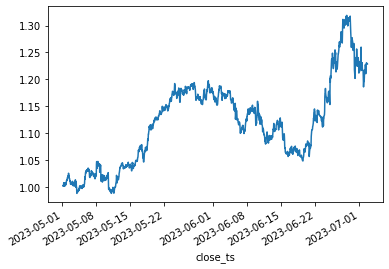

In [181]:
c_agg.plot()